In [1]:
import numpy as np 
import geopandas as gpd
import rasterio
import shapely
import pyproj
import matplotlib.pyplot as plt

from rasterio import mask
%matplotlib inline
import requests
from io import BytesIO

import ee

In [2]:
year = 2016
root = f'/Users/alexthomas/Downloads/nbac_{year}_20240530'
path = f'nbac_{year}_20240530.shp'

print('starting to read shapefile:')
shape_file = gpd.read_file(f'{root}/{path}')
print('finished reading shapefile!')

starting to read shapefile:
finished reading shapefile!


In [3]:
df = shape_file

print(df.columns.tolist())
print(df.info())
print('\n\n', df.describe())

['YEAR', 'NFIREID', 'BASRC', 'FIREMAPS', 'FIREMAPM', 'FIRECAUS', 'HS_SDATE', 'HS_EDATE', 'AG_SDATE', 'AG_EDATE', 'CAPDATE', 'POLY_HA', 'ADJ_HA', 'ADJ_FLAG', 'ADMIN_AREA', 'NATPARK', 'PRESCRIBED', 'VERSION', 'GID', 'geometry']
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   YEAR        987 non-null    float64 
 1   NFIREID     987 non-null    float64 
 2   BASRC       987 non-null    object  
 3   FIREMAPS    987 non-null    object  
 4   FIREMAPM    987 non-null    object  
 5   FIRECAUS    987 non-null    object  
 6   HS_SDATE    303 non-null    object  
 7   HS_EDATE    303 non-null    object  
 8   AG_SDATE    969 non-null    object  
 9   AG_EDATE    565 non-null    object  
 10  CAPDATE     458 non-null    object  
 11  POLY_HA     987 non-null    float64 
 12  ADJ_HA      987 non-null    float64 
 13  ADJ_FLAG    680 non-null  

In [11]:

percentile_95 = df['ADJ_HA'].quantile(0.95)
print(f'95th percentile of ADJ_HA: {percentile_95}')
filtered_df = df[df['ADJ_HA'] > percentile_95].sort_values(by='ADJ_HA', ascending=False)

print(filtered_df.describe())

print(filtered_df.crs)


tiff_srs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
crs = pyproj.CRS.from_epsg(4326)
gdf = filtered_df.to_crs(crs)

95th percentile of ADJ_HA: 2476.6264256679956
         YEAR      NFIREID        POLY_HA         ADJ_HA
count    50.0    50.000000      50.000000      50.000000
mean   2016.0   198.080000   21576.425197   21545.049629
std       0.0   211.651894   67514.351060   67522.784638
min    2016.0     9.000000    2497.388499    2497.388499
25%    2016.0    57.000000    3804.500524    3722.467128
50%    2016.0   145.500000    5906.945912    5906.945912
75%    2016.0   250.250000   18209.465571   18209.465571
max    2016.0  1167.000000  477420.934177  477420.934177
PROJCS["NAD83_/_NRCan_LCC_Canada",GEOGCS["unknown",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["false_easting",0],PARAMETER["false_northing",0],PARAMETER["central_meridian",-95],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",77],PARAMETER["latitude_of_

In [12]:
print(gdf.crs)
pre_geom = filtered_df.iloc[0].geometry.bounds
print(pre_geom)
geom = gdf.iloc[0].geometry
print(geom.bounds)



EPSG:4326
(-1013055.7254000008, 906299.4748999998, -884235.2675999999, 1003965.6889999993)
(-112.07387080948027, 56.20049712891124, -109.9999980706172, 57.004711684190426)


In [13]:
instance = gdf.iloc[0]
print(instance)
print(instance.geometry.bounds)

YEAR                                                     2016.0
NFIREID                                                   255.0
BASRC                                                    MAFiMS
FIREMAPS                                                Landsat
FIREMAPM                                      Processed imagery
FIRECAUS                                           Undetermined
HS_SDATE                                             2016-05-01
HS_EDATE                                             2016-08-06
AG_SDATE                                             2016-05-01
AG_EDATE                                                   None
CAPDATE                                              2016-10-03
POLY_HA                                           477420.934177
ADJ_HA                                            477420.934177
ADJ_FLAG                                                   None
ADMIN_AREA                                                   AB
NATPARK                                 

In [29]:

global_FA = gpd.read_file(f'/Users/alexthomas/Desktop/EE_Fire/CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_V1_perimeter_{year}/Global_fire_atlas_V1_perimeter_{year}.shp')


In [42]:
global_ignitions = gpd.read_file(f'/Users/alexthomas/Desktop/EE_Fire/CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_V1_ignitions_{year}/Global_fire_atlas_V1_ignitions_{year}.shp')

In [48]:

ignitions_filtered = global_ignitions[global_ignitions['size'] > 10].sort_values(by='size', ascending=False)
print(len(ignitions_filtered))
print(ignitions_filtered.columns)
print(ignitions_filtered.iloc[0].size)
case = ignitions_filtered[ignitions_filtered['geometry'].apply(lambda x: x.within(geom))] 


63378
Index(['fire_ID', 'latitude', 'longitude', 'size', 'perimeter', 'start_date',
       'start_DOY', 'end_date', 'end_DOY', 'duration', 'expansion',
       'fire_line', 'speed', 'direction', 'direction_s', 'landcover',
       'landcover_s', 'tile_ID', 'geometry'],
      dtype='object')
19


In [47]:
print(case)

       fire_ID  latitude  longitude     size  perimeter  start_date  \
34569    34570   56.6604   -111.410  1547.32     799.14  2016-05-01   
34540    34541   56.6479   -111.676   369.79     295.39  2016-05-12   
34582    34583   56.6854   -110.892   204.29     246.32  2016-05-04   
34534    34535   56.8646   -110.173   157.56     186.13  2016-05-15   
34587    34588   56.7563   -110.273   129.91     127.79  2016-05-15   
34541    34542   56.6438   -111.694   110.83     112.97  2016-05-12   
34559    34560   56.7646   -110.989    71.17     102.79  2016-05-15   
34610    34611   56.6688   -110.214    54.66      63.89  2016-05-08   
34698    34699   56.3188   -110.524    49.52      61.12  2016-05-06   
34583    34584   56.6479   -110.767    49.30      77.78  2016-05-04   
34627    34628   56.6188   -110.091    42.23      64.82  2016-05-17   
34552    34553   56.8646   -110.676    35.37      50.00  2016-05-17   
34551    34552   56.8396   -111.227    30.44      48.15  2016-05-16   
34535 

In [61]:
print(global_FA.columns)
global_filtered = global_FA[global_FA['size'] > 10]
global_sorted = global_filtered.sort_values(by='size', ascending=False)
fires = global_sorted[global_sorted['geometry'].apply(lambda x: x.intersects(geom))] 


print(len(global_filtered))


Index(['fire_ID', 'lat', 'lon', 'size', 'perimeter', 'start_date', 'start_DOY',
       'end_date', 'end_DOY', 'duration', 'expansion', 'fire_line', 'speed',
       'direction', 'direction_s', 'landcover', 'landcover_s', 'tile_ID',
       'geometry'],
      dtype='object')
63392


In [62]:
import pprint
print(fires)

       fire_ID      lat      lon     size  perimeter  start_date  start_DOY  \
34711    34570  56.6604 -111.403  1547.32     799.14  2016-05-01        122   
34599    34541  56.6479 -111.670   369.79     295.39  2016-05-12        133   
34620    34583  56.6854 -110.885   204.29     246.32  2016-05-04        125   
34568    34535  56.8646 -110.165   157.56     186.13  2016-05-15        136   
34587    34588  56.7562 -110.266   129.91     127.79  2016-05-15        136   
34617    34542  56.6437 -111.688   110.83     112.97  2016-05-12        133   
34630    34571  56.6312 -110.461    74.17      87.04  2016-05-04        125   
34585    34560  56.7646 -110.982    71.17     102.79  2016-05-15        136   
34606    34611  56.6688 -110.207    54.66      63.89  2016-05-08        129   
34712    34699  56.3187 -110.517    49.52      61.12  2016-05-06        127   
34605    34584  56.6479 -110.760    49.30      77.78  2016-05-04        125   
34634    34628  56.6188 -110.083    42.23      64.82

data crs: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs +type=crs
gdf crs: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs +type=crs
start date: 122
end date: 150
{'coordinates': (((-6675701.831898554, 6249216.918834911),
                  (-6675701.831898554, 6338641.71137262),
                  (-6864640.373283452, 6338641.71137262),
                  (-6864640.373283452, 6249216.918834911),
                  (-6675701.831898554, 6249216.918834911)),),
 'type': 'Polygon'}
136.0
(195, 409)
| 463.31, 0.00,-6864904.52|
| 0.00,-463.31, 6339044.59|
| 0.00, 0.00, 1.00|


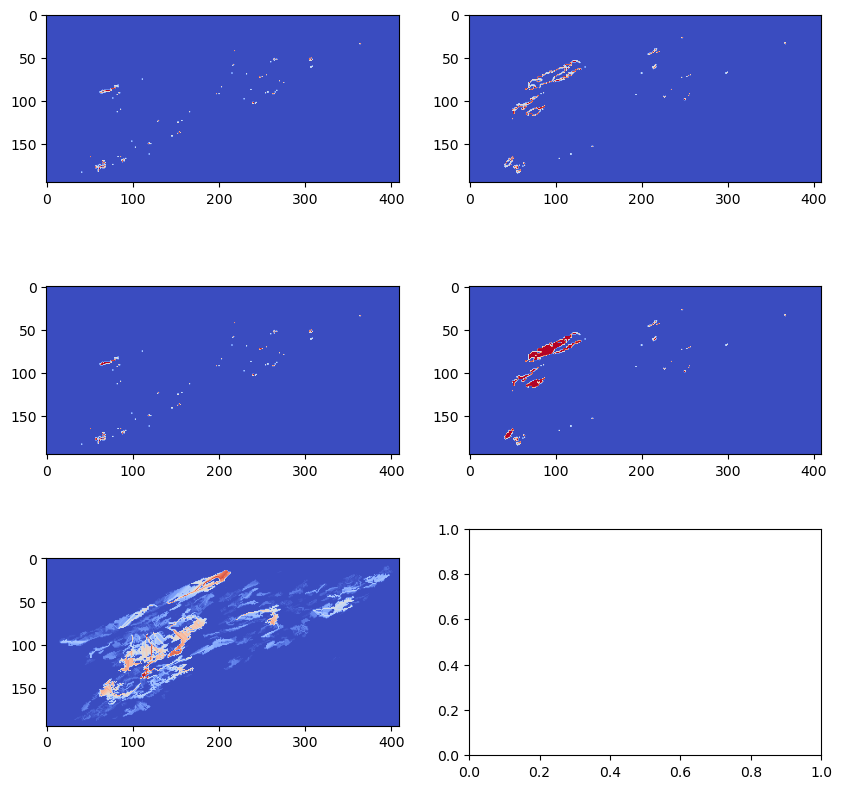

In [77]:
import rasterio.features



tiff_srs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"


# Create a CRS object using the proj4 string
tiff_crs = pyproj.CRS.from_proj4(tiff_srs)
fires = fires.to_crs(tiff_srs)


#See the switch in crs
print("data crs:", fires.crs)
print("gdf crs:",gdf.crs)

# Load GeoTiff representing day-of-year of the burn
file_1 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_fire_line_yearly_2016.tif'
file_2 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif'
file_3 = 'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_speed_yearly_2016.tif'

with rasterio.open(file_1) as src:
    with rasterio.open(file_2) as second:
        with rasterio.open(file_3) as third:
            index = 0
            start_date = fires.iloc[index].start_DOY
            end_date = fires.iloc[index]['end_DOY']
            print(f"start date: {start_date}")
            print(f"end date: {end_date}")
            
            
            #Tuple of coords
           # shape = fires.iloc[index].geometry.bounds
            shape = geom.bounds
            #Shapely polygon
            box = shapely.geometry.box(shape[0], shape[1], shape[2], shape[3]) 
   
            json = shapely.geometry.mapping(box)
            
            pprint.pprint(json)
            arr, out = rasterio.mask.mask(src, [json], crop = True, nodata = 0, pad = 1)
            arr2, out = rasterio.mask.mask(second, [json], crop = True, nodata = 0, pad = 1)
            arr3, out = rasterio.mask.mask(third, [json], crop = True, nodata = 0, pad = 1)
            
            
         # print(arr[0].shape)
            #  print(arr[0])
            fig = plt.figure(figsize=(10,10))
            ax1 = fig.add_subplot(321)
            ax2 = fig.add_subplot(322)
            ax3 = fig.add_subplot(323)
            ax4 = fig.add_subplot(324)
            ax5 = fig.add_subplot(325)
            ax6 = fig.add_subplot(326)
        
        
            day = (end_date+start_date)/2
            print(day)
            
            ax1.imshow((arr[0] == day).astype(int), cmap = 'coolwarm')
            ax2.imshow((arr[0] == day+1).astype(int), cmap = 'coolwarm')
            ax3.imshow((arr2[0] == day).astype(int), cmap = 'coolwarm')
            ax4.imshow((arr2[0] == day+1).astype(int), cmap = 'coolwarm')
            ax5.imshow(np.squeeze(arr3), cmap = 'coolwarm')
      
            
            print(arr[0].shape)
            print(out)



In [14]:
year = 2016
root = f'/Users/alexthomas/Downloads/nbac_{year}_20240530'
path = f'nbac_{year}_20240530.shp'

print('starting to read shapefile:')
df = gpd.read_file(f'{root}/{path}')
print('finished reading shapefile!')

print('starting big')
global_FA = gpd.read_file(f'/Users/alexthomas/Desktop/EE_Fire/CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_V1_perimeter_{year}/Global_fire_atlas_V1_perimeter_{year}.shp')
print('finished big')


starting to read shapefile:
finished reading shapefile!
starting big
finished big


In [15]:

percentile_95 = df['ADJ_HA'].quantile(0.95)
print(f'95th percentile of ADJ_HA: {percentile_95}')
filtered_df = df[df['ADJ_HA'] > percentile_95].sort_values(by='ADJ_HA', ascending=False)

print('filtered canadian fires sucessfully')
tiff_srs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

big_fires = filtered_df.to_crs(tiff_srs)

print(f'changed crs')

global_filtered = global_FA[global_FA['size'] > percentile_95/1000]
print('filtered by 0.95')
global_sorted = global_filtered.sort_values(by='size', ascending=False).to_crs(tiff_srs)
print('sorted and changed crs')

print('crs are equal:', big_fires.crs == global_sorted.crs)

merged_fires = gpd.overlay(big_fires, global_sorted, how='intersection')


geometry = big_fires.iloc[0].geometry
print(geometry.bounds)

fires = global_sorted[global_sorted['geometry'].apply(lambda x: x.intersects(geometry))] 


print(len(fires))



95th percentile of ADJ_HA: 2476.6264256679956
filtered canadian fires sucessfully
changed crs
filtered by 0.95
sorted and changed crs
crs are equal: True
(-6864640.373283452, 6249216.918834911, -6675701.831898554, 6338641.71137262)
45


In [27]:
print(len(merged_fires))

print(merged_fires['size'].unique())
merged_fires.describe()


215
[1547.32  369.79  204.29  157.56  129.91  110.83   74.17   71.17   54.66
   49.52   49.3    42.23   35.37   30.44   27.44   27.22   24.87   20.79
   19.94   16.29   16.08   15.86   13.93   13.29   11.79   10.72   10.29
    9.65    9.43    6.86    6.65    5.36    4.93    4.72    4.29    3.86
    3.43    3.22    2.79    2.57  589.73   73.1    37.09   11.36    3.
  258.53   79.96   21.87   17.58   14.58   13.08   12.65   12.22    8.79
    7.29    6.    412.02   81.89   23.58   28.51   26.8    22.29   21.44
   15.43   15.01   11.15   10.93    7.5     7.07   67.1    31.94   26.37
   17.15    8.15   45.45   12.      5.57    4.5    96.89   40.73   24.01
   14.15   76.32   47.59    7.72  211.8     8.57  180.5    14.36  146.84
    9.86    7.93    5.14  140.84   37.94    9.    101.18   69.46    6.22
   44.59   16.72   83.18   55.52   41.16   21.22   28.73   16.94   32.16
   18.01   12.43   26.15   18.65   52.73   41.59   14.79   13.51   20.37
   19.51   22.94    9.22   17.36   18.86   30.01 

,YEAR,NFIREID,POLY_HA,ADJ_HA,fire_ID,lat,lon,size,perimeter,start_DOY,end_DOY,duration,expansion,fire_line,speed,direction,landcover
count,215.0,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.00000
mean,2016.0,214.627907,117103.571967,117092.319042,48770.446512,58.637007,-111.001253,42.398372,49.616512,165.311628,180.725581,16.413953,2.170512,3.472744,2.961442,5.390698,4.00000
std,0.0,176.761789,186794.765106,186801.591594,12741.899358,3.974564,9.538882,125.172373,75.485623,30.534653,33.953019,8.479265,4.659327,6.017083,2.416501,2.175889,3.46545
min,2016.0,9.000000,2497.388499,2497.388499,34324.000000,49.877100,-134.790000,2.570000,8.330000,79.000000,98.000000,1.000000,0.150000,0.310000,0.760000,0.000000,1.00000
25%,2016.0,66.000000,6048.206688,6048.206688,34616.500000,56.625000,-116.311500,6.755000,18.520000,136.000000,146.000000,11.000000,0.515000,1.100000,1.485000,3.000000,1.00000
50%,2016.0,180.000000,23175.791436,23175.791436,56400.000000,57.652100,-110.483000,13.290000,29.630000,176.000000,192.000000,16.000000,0.930000,1.830000,2.250000,4.000000,1.00000
75%,2016.0,255.000000,67861.058538,67861.058538,56608.500000,62.366700,-107.880000,30.225000,49.080000,193.000000,209.000000,20.500000,1.990000,3.360000,3.365000,8.000000,8.00000
max,2016.0,703.000000,477420.934177,477420.934177,123373.000000,66.477100,-57.569400,1547.320000,799.140000,220.000000,250.000000,55.000000,53.360000,68.300000,16.940000,8.000000,12.00000


In [33]:
import os
import fnmatch

train_lst = [] 
# Assuming 'df' is your DataFrame and 'fire_ID' is the column with the fire IDs
for fire_id in merged_fires['fire_ID']:
    for file in os.listdir('/Users/alexthomas/Desktop/Pytorch/data/train'):
        if fnmatch.fnmatch(file, f'compressed_{fire_id}*'):
            print(f'File found: {file}')
            train_lst.append(file)



File found: compressed_34599_134.npz
File found: compressed_34599_135.npz
File found: compressed_34599_137.npz
File found: compressed_34599_136.npz
File found: compressed_34599_143.npz
File found: compressed_34599_142.npz
File found: compressed_34599_140.npz
File found: compressed_34599_154.npz
File found: compressed_34599_155.npz
File found: compressed_34599_141.npz
File found: compressed_34599_145.npz
File found: compressed_34599_151.npz
File found: compressed_34599_150.npz
File found: compressed_34599_144.npz
File found: compressed_34599_152.npz
File found: compressed_34599_146.npz
File found: compressed_34599_147.npz
File found: compressed_34599_153.npz
File found: compressed_34599_149.npz
File found: compressed_34599_148.npz
File found: compressed_34599_138.npz
File found: compressed_34599_139.npz
File found: compressed_56397_198.npz
File found: compressed_56397_205.npz
File found: compressed_56397_204.npz
File found: compressed_56397_199.npz
File found: compressed_56397_189.npz
F

In [32]:
print(len(train_lst))
print(len(test_lst))

0
0


In [ ]:

import time as t
#i -- day of year as given by tiff
#year -- string of year
# data -- gdf with standard coords
# index -- fire index in geopandas data frame
def getArrays(i, year, data, index):
    
    num_retries = 3
    for l in range(0, num_retries):
        try: #use this to catch the dreaded RemoteDisconnect error
            display(f'\n{i}, initializing data')
            jan1 = ee.Date(year+'-01-01')
            
            t1 = t.time()
        
            roi = ee.Geometry.Rectangle(data.iloc[index].geometry.bounds)
        
            era_hourly = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") #use the hourly for better resolution
           
            era_daily = ee.ImageCollection("ECMWF/ERA5/DAILY") #use daily for aggregate values
           
            terra_vegetation =  ee.ImageCollection("MODIS/061/MOD13A1") # every 16 days resolution
             
             #ee.ImageCollection("MODIS/061/MOD13Q1")  # this is the 250 m resolution one
    
            #reprojected precip
            precipitation = era_daily.filterDate(jan1.advance(i-1,'day'), jan1.advance(i,'day'))\
                                .first()\
                             
            
            tree_cover = terra_vegetation.filterDate(jan1.advance(i-20,'day'), jan1.advance(i,'day'))\
                                                    .first()
            list = era_hourly.filterDate(jan1.advance(i-1, 'day'), jan1.advance(i,'day')).toList(24)
            tree_cover_reprojected = tree_cover.reproject(crs = ee.Projection('EPSG:4326'), scale = 500)#, #\crsTransform = tree_cover.projection().getInfo()['transform'])
        
            wind = ee.Image(list.get(12))#.clip(roi)#.reproject(crs = ee.Projection('EPSG:4326'))
                    
            
    
            ##get download URLS":
    
            display('\nFetching urls:')
            
            v_comp = wind.getDownloadURL({
           
                    'bands': ['v_component_of_wind_10m'],
                    'region': roi,
                    'format': "NPY",
                        
                    })
                                    
            u_comp = wind.getDownloadURL({
           
                    'bands': ['u_component_of_wind_10m'],
                    'region': roi,
                    'format': "NPY",
                        
                    })
        
            precip = precipitation.getDownloadURL({
                    
                    'bands': ['total_precipitation'],
                    'region': roi,
                    'format': "NPY",
           
                    })
        
            non_green_cover = tree_cover_reprojected.getDownloadURL({
        
                ##could use NDVI or EVI
                    'bands': ['NDVI'],
                    'region': roi,
                    'format': "NPY",
           
                    })
        
            display("\nDowloading urls:")
            url_list = [v_comp, u_comp, precip, non_green_cover]
        
            arrays = []
            #for redundancy use a try/ except block and then use if image_array is not None
            
            for url in url_list:
                for i in range(0, num_retries):
                    try:
                        r = requests.get(url, stream = True)
                                
                        display(f"status code: {r.status_code} ")
                                
                        if r.status_code != 200:
                            r.raise_for_status()
                                
                        arr = np.array(np.load(BytesIO(r.content)).tolist())
                        arrays.append(arr)
                        break
                         
                    except requests.exceptions.RequestException as e:
                        display(f"Error Downloading {url}:{e}")
                        display('\nretrying:')
                        t.sleep(5)
            
            t2 = t.time()
            display(t2-t1)
            return arrays
            break
        except Exception as e:
            error_type = type(e).__name__
            with open('errors.txt', 'w') as f:
                str = f"error at index : {index}, {error_type}"
                display(str)
                f.write(str)
                t.sleep(5)
                display('\nretrying')
        
        return None
    

In [38]:
from IPython.display import clear_output, display

def getData(year, files, data, gdf):
    #gdf -- in geotiff coordinates
    #data  -- in standard coordinates
    

    dict = {}
    times = []
    with rasterio.open(files[0]) as dob: #day of burn
        with rasterio.open(files[1]) as fire_line: #fire line
          
            # Iterate over each forest fire
            count = 0
            
            for index, row in gdf.iterrows(): 
                
                display(f'\n\nindex: {index}')
                start_date = row['start_DOY']
                end_date = row['end_DOY']
        
                if(end_date < start_date):
                    end_date = 365
        
                
                display(f"\nstart date: {start_date}")
                display(f"end date: {end_date}\n")
        
        
                #Tuple of coords
                bounds = row.geometry.bounds
                
                #Shapely polygon
                box = shapely.geometry.box(bounds[0], bounds[1], bounds[2], bounds[3]) 
                json = shapely.geometry.mapping(box)
                
                dob_tiff, out = rasterio.mask.mask(dob, [json], crop = True, nodata = 0, pad = 1 )
   
                fire_line_tiff, out2 = rasterio.mask.mask(fire_line, [json], crop = True, nodata = 0, pad = 1)

                temp = getArrays(start_date, year, data, count)
                temp.insert(0, (dob_tiff[0] == start_date).astype(int))
                temp.insert(1, (fire_line_tiff[0]== start_date).astype(int))
                    
    
                #change this to for every date pair in the sequence

          
                for i in range(start_date, end_date-1):
                    clear_output()
                        
                        ## pre is the same as arr[i-1]
                    pre = temp
                        #temp is same as arr[i]
                    temp = getArrays(i, year, data, count)


                    if(temp!=None):
                        try:
                            temp.insert(0, (dob_tiff[0] == i).astype(int))
                            temp.insert(1, (fire_line_tiff[0]== i).astype(int))
                                #this makes it 0 indexed not indexed from the DOB like 266
                        
                                
                                
                                        
                            arr0, arr1, arr2, arr3, arr4, arr5 = pre[0], pre[1], pre[2], pre[3], pre[4], pre[5]
                            dob, fire_line= temp[0], temp[1]
                                
                            np.savez_compressed(f'compressed_{index}_{i}.npz', array1=arr0, array2=arr1, array3 = arr2, array4 = arr3, 
                                        array5 = arr4, array6 = arr5, array7 = dob, array8 = fire_line)
                            display(f'saved at {index}, {i}')
                                
                           
                        except Exception as e:
                                print(f'exception at {i}: {e}')
                    else: ##this is the error handling for the extended try / except block in getArrays().;jyuiop
                        pass
                    
                    
                count+=1

 
    return dict, times

ee.Authenticate()

In [40]:
ee.Authenticate()


Successfully saved authorization token.


In [41]:
ee.Initialize()


In [42]:
import time
file_1 = root+'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_fire_line_yearly_2016.tif'
file_2 = root+'CMS_Global_Fire_Atlas_1642/data/Global_fire_atlas_day_of_burn_yearly_2016.tif'

#files need to be in this format
#files = [DOY, fire_line]

files = [file_1, file_2]


#initialize crs conversion
tiff_srs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
tiff_crs = pyproj.CRS.from_proj4(tiff_srs)

#define data (recall sorted definition from earlier)
data = sorted.iloc[0:50] 

tiff_data = data.to_crs(tiff_srs)


year = '2016'


#output format should be like this
#dict = { 'fire id (8172640): list}
#list = [DOB, fire_line, u_comp_wind, v_comp_wind, precipitation, forest cover]

dict = getData(year, files, data, tiff_data)




AttributeError: 'builtin_function_or_method' object has no attribute 'iloc'